In [24]:
from __future__ import print_function, division

In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
import qgrid

import numpy as np
from numpy import diff
import math

import pandas as pd
import xarray as xr

import climlab
from climlab.solar.insolation import daily_insolation
from climlab.radiation import DailyInsolation
from climlab.radiation import FixedInsolation
from climlab.process import TimeDependentProcess


from IPython.display import HTML



import scipy as scp
from attrdict import AttrDict
from datetime import datetime

import dask.dataframe as dd

import warnings

import antarctic_rad as ar

## Data

Read data and concatenate into one dataset.

level 0 = Surface

level 110 = TOA

(our data is in the order TOA-->Surface)

In [27]:
###### load atm and gas files into dataframes ######
atm_df = pd.concat(pd.read_excel('../schmit_data/schmit_compiled_temp_data_final.xlsx', #read in atm data
                                 sheet_name=None,   # import all sheets in the excel
                                 na_values=np.nan), # convert nan to numpy nan values
                   axis=0) #concatenate along 0th axis
gas_df = pd.concat(pd.read_excel('../schmit_data/schmit_compiled_gas_data.xlsx', #read in gas data
                                 sheet_name=None,   # import all sheets in the excel
                                 na_values=np.nan), # convert nan to numpy nan values
                   axis=0) #concatenate along 0th axis and flip
df = pd.concat([atm_df,gas_df],axis=1, sort=True) #concatenate gas and atm data into one dataframe

###### create our overall dataset and rename coordinates #####

ds = xr.Dataset(df).unstack() #create dataset and unstack our coordinates
ds = ds.rename({'dim_0_level_0': 'month'}) #rename coordinate
ds = ds.rename({'dim_0_level_1': 'level'}) #rename coordinate
for var_idx, var_name in enumerate(ds.variables): #transpose our data
    ds[var_name] = ds[var_name].transpose()
ds['spec_humidity']=(ds['H2O']/(1+ds['H2O'])) #add in specific humidity
ds = ds.reindex(level=ds.level[::-1]) #reindex our data so it reads from top to bottom
ds.__delitem__('CO2') #delete unused variables
ds.__delitem__('CO') #delete unused variables
ds.__delitem__('CH4') #delete unused variables
ds.__delitem__('Height') #delete unused variables
ds['CO2_list'] = np.array([100.,200.,380.,760.,1000.,1500.])/(1e6) #list of CO2 values we will use

ds.attrs['name'] = 'all'

In [28]:
######### calculate mean insolation for each month and add to dataset #########

month_days = [31,28,31,30,31,30,31,31,30,31,30,31] #list of the number of days in a month
day_of_month = [
    np.cumsum(month_days) - np.array(month_days),
    np.cumsum(month_days)
] #list of first and last day of each month
day_num = np.arange(1,366) #number of days in a year
month_num  = np.arange(0,12) #number of months in a year

insolation = np.zeros(len(day_num)) #insolation for each day
monthly_insol = np.zeros(len(month_num)) #insolation for each month
for day in day_num: #calculate daily insolation
    insolation[day-1] = daily_insolation(lat = -90, day = day)
for month in month_num: #calculate monthly mean insolation
    monthly_insol[month] = insolation[day_of_month[0][month]:day_of_month[1][month]].mean()
ds['monthly_insolation'] = xr.DataArray(data = monthly_insol, dims = 'month') #add into our dataset

In [29]:
#create dataset that includes stratosphere up to 60km
ds_strat_lev = 96
ds_strat = ds.sel(level=slice(ds_strat_lev,0))
ds_strat.attrs['name'] = 'strat'
#modify our dataset to skip levels near the surface so that it is more spaced out
#ds_strat = ds_strat.drop(level = [1,2,3,4,5,6,7,9,10,11,12,14,15,17,18,20,22,24]) drops to one every 100m
#ds_strat = ds_strat.drop(level = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,17,18,19,20,21,22,24]) #drops to one every 300m
ds_strat = ds_strat.drop(level = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,22,23,24,25,26,27,28]) #drops to one every 500m for the first 1000m
#ds_strat = ds_strat.drop(level = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28]) #drops to one every 1000m

ds_strat['level'] = np.flip(np.arange(ds_strat['level'].size))
ds_strat['Altitude'].sel(month = 'January')

<xarray.DataArray 'Altitude' (level: 70)>
array([60000.  , 55000.  , 50000.  , 45000.  , 40000.  , 39980.  ,
       35000.  , 30000.  , 29165.32, 25925.55, 23701.35, 22005.73,
       20635.09, 19484.67, 18493.41, 17622.56, 16846.02, 16145.35,
       15507.02, 14920.85, 14378.96, 13875.11, 13404.32, 12962.52,
       12546.34, 12152.97, 11780.04, 11425.53, 11087.71, 10765.07,
       10456.32, 10160.29,  9876.  ,  9602.53,  9339.1 ,  9085.  ,
        8839.59,  8602.29,  8372.58,  8150.  ,  7934.11,  7724.52,
        7520.88,  7322.86,  7130.15,  6942.49,  6759.6 ,  6581.26,
        6407.24,  6237.34,  6071.37,  5909.15,  5750.51,  5595.31,
        5443.39,  5294.62,  5148.86,  5006.01,  4865.95,  4728.57,
        4593.76,  4461.45,  4331.52,  4239.35,  4127.39,  4023.57,
        3927.29,  3838.02,  3321.89,  2827.  ])
Coordinates:
    month    <U7 'January'
  * level    (level) int64 69 68 67 66 65 64 63 62 61 60 ... 9 8 7 6 5 4 3 2 1 0

# Climlab

#### All tendencies must be in K/sec (see Climlab energy_budget documentation and self.heating_rate attribute): https://climlab.readthedocs.io/en/latest/_modules/climlab/process/energy_budget.html#EnergyBudget

In [30]:
###### create a Turbulence class #######
class Turbulence(TimeDependentProcess):
    #class turbulence that decays with height computed from:
    # theta = Tatm(P0/Patm)^R/Cp
    # k0 = Net surface flux/(dtheta/dz) at surface 
    # ka = k0*exp(-z/d) in atmosphere
    # -ka * dtheta/dz is turbulent flux in the atmosphere 
    
    def __init__(self, **kwargs):
        #define initial state
        super(Turbulence, self).__init__(**kwargs) #initialize our model
        self.experiment = experiment #name the experiment as part of the model
        self.time_type = 'explicit' #explicit time calculations
        ### add new diagnostics
        self.add_diagnostic('total_sfc_flux_init', 0. * self.Ts)
        self.add_diagnostic('theta_init', 0. * (self.Tatm+1))
        self.add_diagnostic('dtheta_dz_surf_init', 0. * self.Ts)
        self.add_diagnostic('surface_diffk', 0. * self.Ts)
        self.add_diagnostic('theta', 0. * (self.Tatm+1))
        self.add_diagnostic('dtheta_dz', 0. * (self.Tatm+1))
        self.add_diagnostic('atm_diffk', 0. * (self.Tatm+1))
        self.add_diagnostic('atm_turbulent_flux', 0. * (self.Tatm+1))
        self.add_diagnostic('sfc_turbulent_flux', 0. * self.Ts)
        self.add_diagnostic('atm_hr', 0. * self.Tatm)
        self.add_diagnostic('sfc_hr', 0. * self.Ts)
        self.add_diagnostic('hr', 0. * (self.Tatm+1))
        self.add_diagnostic('z', 0. * self.Tatm)
        self.add_diagnostic('z_bounds', 0. * self.Tatm)

        ### define new levels
        #n+1 pressure level (lev_boundsin climlab) reworked so that we are no longer using 0 and 1000 as our TOA and surface
        self.lev_bounds[0] = self.lev_bounds[1]-2*(self.lev_bounds[1] - self.lev[0])
        self.lev_bounds[-1] = self.lev_bounds[-2]+2*(self.lev[-1] - self.lev_bounds[-2])
        #altitude (n)
        self.z = (self.experiment['Altitude'].sel(month = m)- self.experiment['Altitude'].sel(month = m).isel(level = -1))
        #altitude bounds (n)
        self.z_bounds = np.zeros(len(state['Tatm']) +1)
        for n in range(len(state['Tatm'])-1):
            self.z_bounds[n+1] = ((self.z[n]+self.z[n+1])/2)
        self.z_bounds[0] = (ds['Altitude'].sel(month = m).sel(level = ds_strat_lev +1) + experiment['Altitude'].sel(month = m).sel(level = len(experiment['Altitude'])-1))/2 - experiment['Altitude'].sel(month = m).isel(level = -1)
        self.z_bounds[-1] = (self.z[-1]+self.z[-2])/2
        ### calculate turbulent flux
        #surface flux (LW + SW)
        self.total_sfc_flux_init = (rad.diagnostics['SW_sfc_clr']- rad.diagnostics['LW_sfc_clr']) #W/m^2
        #gas constant / specific heat of air
        R = 287 #gas constant of air J/kg*K (at 250 K)
        cp_air = 1003 #specific heat of air (at 250 K) J/(kg*K)
        density = 1.05 #density of air kg/m^3
        self.R_cp = R/cp_air 
        self.theta_init = np.zeros(len(state['Tatm']) +1)
        self.theta_init[:-1] = self.state['Tatm']*(np.asarray(experiment['Pressure'].sel(month = m).isel(level = -1))/self.lev)**(self.R_cp)#K
        self.theta_init[-1] = self.state['Ts']*(np.asarray(experiment['Pressure'].sel(month = m).isel(level = -1))/np.asarray(experiment['Pressure'].sel(month = m).isel(level = -1)))**(self.R_cp) #K
        #dtheta_dz_init (just need the first value of dtheta/dz)
        self.dtheta_dz_surf_init = (np.diff(self.theta_init)/np.diff(self.z))[-1] #K/m
        #surface diffk (m2/s)
        self.surface_diffk = -0.34498416 #m^2/s
        #atmospheric diffk (n+1)
        scale_factor = 100 #m
        self.atm_diffk = self.surface_diffk * (np.exp(-self.z_bounds/scale_factor)) #m^2/s
        

    def _compute(self):
        #constants
        cp_air = 1003 #specific heat of air (at 250 K) J/(kg*K)
        cp_ice = 2060 #specific heat of ice
        density = 1.05 #density of air kg/m^3
        density_ice = 900 #kg/m^3
        #surface flux (LW + SW)
        self.total_sfc_flux = (rad.diagnostics['SW_sfc_clr']- rad.diagnostics['LW_sfc_clr']) #W/m^2
        #theta (length of n)
        self.theta = np.zeros(len(state['Tatm']) +1)
        self.theta[:-1] = self.state['Tatm']*(np.asarray(experiment['Pressure'].sel(month = m).isel(level = -1))/self.lev)**(self.R_cp)#K
        self.theta[-1] = self.state['Ts']*(np.asarray(experiment['Pressure'].sel(month = m).isel(level = -1))/np.asarray(experiment['Pressure'].sel(month = m).isel(level = -1)))**(self.R_cp) #K        
        #dtheta_dz_init (length of n+1)
        self.dtheta_dz = np.zeros(len(state['Tatm']) +1)
        self.dtheta_dz[1:] = np.diff(self.theta)/np.diff(self.z)
        self.dtheta_dz[0] =  0 #TOA flux is zero
        #calculate the atmospheric turbulent flux
        self.atm_turbulent_flux = -self.atm_diffk * self.dtheta_dz #K*m/s
        #calculate/prescribe surface turbulent flux
        self.sfc_turbulent_flux = self.total_sfc_flux/(cp_ice*density_ice) #K*m/s
        # calculate heating rate (flux convergence) from flux and convert into K/sec (which is the heating rate output in climlab)
        self.atm_hr = (np.diff(self.atm_turbulent_flux)/np.diff(self.z_bounds)) #K/sec
        self.sfc_hr= ((np.asarray(self.atm_turbulent_flux[-1])-np.asarray(self.sfc_turbulent_flux))/(np.asarray(self.z_bounds[-1])-np.asarray(self.z[-1]))) #K/sec
        self.hr = np.concatenate([ram.subprocess.Turbulence.atm_hr,ram.subprocess.Turbulence.sfc_hr])        
        tendencies = {'Tatm' : self.atm_hr, 'Ts' : self.sfc_hr}
        
        # check that CFL condition is met
        self._CFL = self.surface_diffk*(self.time['timestep']/(np.diff(self.z_bounds)**2))[-1] 
        if self._CFL > 1.:
            warnings.warn(f"CFL Condition not met, {self._CFL}, timestep too large or lower level z difference too small for {m}, CO2 {CO2} kg/kg")
        return tendencies

In [191]:
####### set up climlab ########

months = (np.asarray(ds['month'])) #list of months
exp_list = [ds_strat] #list of experiments
albedo = .8 
timestep = 200. 

#set up the radiative-advective model (ram)
ram_dict = {} #create our ram_dict for the output of each instance of ram (2 experiments x 6 CO2 levels x 12 months)
for experiment in exp_list:
    ram_dict[experiment.name] = {}
    for CO2 in experiment['CO2_list'].values:
        ram_dict[experiment.name][CO2] = {}
        for m in months:
            ram_dict[experiment.name][CO2][m] = {}
            ###create ram state, radiation model, and TimeDepedent ram model instance
            
            #create two domains: atm and surface
            sfc, atm=climlab.domain.single_column(lev=experiment['Pressure'].sel(month=m).isel(level = slice(0,-1)).values);
            #create an atmospheric state
            state = AttrDict()
            #set up a surface temperature profile 
            T_s=climlab.Field(experiment['Temperature'].isel(level=-1).sel(month=m).values, domain=sfc);
            state['Ts']=T_s #K
            #set up an atmospheric temperature profile
            T_atm=climlab.Field(experiment['Temperature'].sel(month=m).isel(level = slice(0,-1)).values, domain=atm);
            state['Tatm']=T_atm #K
                        
            #radiation model setup
            rad = climlab.radiation.RRTMG(name='Radiation(all gases)', state = state,
                                              specific_humidity = experiment['spec_humidity'].sel(month = m).isel(level = slice(0,-1)).values,
                                              albedo = albedo,
                                              timestep = timestep,
                                              ozone_file = None,
                                              S0 = 1365.2,
                                              insolation = ds_strat['monthly_insolation'].sel(month = m).values,
                                              isolvar = 1 #see https://climlab.readthedocs.io/en/latest/_modules/climlab/radiation/rrtm/rrtmg_sw.html#RRTMG_SW._compute_heating_rates 
                                                          #1 = Solar variability (using NRLSSI2  solar
                                                            # model) with solar cycle contribution
                                                            # determined by fraction of solar cycle
                                                            # with facular and sunspot variations
                                                            # fixed to their mean variations over the
                                                            # average of Solar Cycles 13-24;
                                                            # two amplitude scale factors allow
                                                            # facular and sunspot adjustments from
                                                            # mean solar cycle as defined by indsolvar
                                            )
            rad.absorber_vmr['O3'] = experiment['O3'].sel(month = m).isel(level = slice(0,-1)).values #kg/kg
            rad.absorber_vmr['CO2'] = CO2 #kg/kg
            #create ram
            ram = climlab.TimeDependentProcess(state = state, timestep = timestep)
            #add latitude axis
            lat = climlab.domain.axis.Axis(axis_type='lat', points=-90.)
            ram.domains['Ts'].axes['lat'] = lat
            #add radiation
            ram.add_subprocess('Radiation', rad)
            #compute ram
            ram.compute()
            #turbulence model setup (coupled to rad model, experiment, and month)
            turb = Turbulence(name = 'Turbulence', state=state, rad = rad, month = m, experiment = experiment, timestep = timestep)
            #add turbulence
            ram.add_subprocess('Turbulence', turb) #add insolation subprocess
            #compute ram
            ram.compute()
            #advective model setup (coupled to rad model)
            adv = climlab.process.external_forcing.ExternalForcing(state = state, turb = turb, ram = ram)
            normal_advection = -((ram.TdotSW_clr + ram.TdotLW_clr)/climlab.constants.seconds_per_day + turb.atm_hr)
            #modified_advection = -(np.concatenate((np.array([0,1.5,3,4.5,6,7.5,9]),(np.asarray(ram.TdotSW_clr - ram.TdotLW_clr - turb._atm_hr)[7:])),axis = 0))
            adv.forcing_tendencies['Tatm'] = normal_advection 
            #add advection
            ram.add_subprocess('Advection', adv)
            #compute ram
            ram.compute()
            #add to dictionary
            ram_dict[experiment.name][CO2][m] = ram


# Output (initial and over time)

### Initial

In [192]:
###set up lists and variables
diagnostics_list = list(ram_dict[experiment.name][CO2][m].diagnostics.keys())
temp_list = ['Ts','Tatm']
adv_dict = {'advection_Ts':'Ts','advection_Tatm':'Tatm'}
output_list = temp_list + diagnostics_list + list(adv_dict.keys()) + ['lev_bounds']
print(output_list)
print('CO2 values ' + str(experiment['CO2_list'].values))
print('timestep ' + str(timestep) + ' seconds')

['Ts', 'Tatm', 'OLR', 'OLRclr', 'OLRcld', 'TdotLW', 'TdotLW_clr', 'LW_sfc', 'LW_sfc_clr', 'LW_flux_up', 'LW_flux_down', 'LW_flux_net', 'LW_flux_up_clr', 'LW_flux_down_clr', 'LW_flux_net_clr', 'ASR', 'ASRclr', 'ASRcld', 'TdotSW', 'TdotSW_clr', 'SW_sfc', 'SW_sfc_clr', 'SW_flux_up', 'SW_flux_down', 'SW_flux_net', 'SW_flux_up_clr', 'SW_flux_down_clr', 'SW_flux_net_clr', 'total_sfc_flux_init', 'theta_init', 'dtheta_dz_surf_init', 'surface_diffk', 'theta', 'dtheta_dz', 'atm_diffk', 'atm_turbulent_flux', 'sfc_turbulent_flux', 'atm_hr', 'sfc_hr', 'hr', 'z', 'z_bounds', 'advection_Ts', 'advection_Tatm', 'lev_bounds']
CO2 values [0.0001  0.0002  0.00038 0.00076 0.001   0.0015 ]
timestep 200.0 seconds


In [193]:
### create dictionary for results
results_dict = {}

In [194]:
### results at first timestep
results_dict[0] = {}
for output in output_list:
    results_dict[0][output] = {}
    for CO2 in ds['CO2_list'].values:
        results_dict[0][output][CO2] = {}
        for m in months:
            results_dict[0][output][CO2][m] = {}
            if output in (diagnostics_list):
                results_dict[0][output][CO2][m] = (ram_dict[experiment.name][CO2][m].diagnostics[output])
            if output in temp_list:
                results_dict[0][output][CO2][m] = list(ram_dict[experiment.name][CO2][m].state[output])
            if output in list(adv_dict.keys()):
                results_dict[0][output][CO2][m] = list(ram_dict[experiment.name][CO2][m].subprocess.Advection.forcing_tendencies[adv_dict[output]])
            if output == 'lev_bounds':
                results_dict[0][output][CO2][m] = list(ram_dict[experiment.name][CO2][m].lev_bounds)


### Timestep forward

In [195]:
steps = 5
### results for each timestep
for i in range(steps):
    #step model forward
    ram_dict[experiment.name][CO2][m].step_forward()
    results_dict[(i+1)*timestep] = {}
    for output in output_list:
        results_dict[(i+1)*timestep][output] = {}
        for CO2 in ds['CO2_list'].values:
            results_dict[(i+1)*timestep][output][CO2] = {}
            for m in months:
                results_dict[(i+1)*timestep][output][CO2][m] = {}
                #add outputs/diagnostics
                if output in (diagnostics_list):
                    results_dict[(i+1)*timestep][output][CO2][m] = (ram_dict[experiment.name][CO2][m].diagnostics[output])
                if output in temp_list:
                    results_dict[(i+1)*timestep][output][CO2][m] = list(ram_dict[experiment.name][CO2][m].state[output])
                if output in list(adv_dict.keys()):
                    results_dict[(i+1)*timestep][output][CO2][m] = list(ram_dict[experiment.name][CO2][m].subprocess.Advection.forcing_tendencies[adv_dict[output]])
                if output == 'lev_bounds':
                    results_dict[(i+1)*timestep][output][CO2][m] = list(ram_dict[experiment.name][CO2][m].lev_bounds)

In [197]:
ram_dict[experiment.name][CO2][m].time

{'timestep': 200.0,
 'num_steps_per_year': 157784.63040000002,
 'day_of_year_index': 5,
 'steps': 5,
 'days_elapsed': 0.011574074074074073,
 'years_elapsed': 0,
 'days_of_year': array([0.00000000e+00, 2.31481481e-03, 4.62962963e-03, ...,
        3.65236111e+02, 3.65238426e+02, 3.65240741e+02]),
 'active_now': True}

In [206]:
CO2_conc = .00038
time1 = (0)*timestep
time2 = (5)*timestep

In [199]:
def plot_LWnet(time1, time2, month):
    fig, ax = plt.subplots()
    plt.plot(list(results_dict[time1]['LW_flux_net'][CO2_conc][month]), list(results_dict[time1]['lev_bounds'][CO2_conc][month]), color = 'C0', label = f'LW net flux at {time1}');
    plt.plot(list(results_dict[time2]['LW_flux_net'][CO2_conc][month]), list(results_dict[time2]['lev_bounds'][CO2_conc][month]), color = 'C1',label = f'LW net flux at {time2}');
    plt.legend()
    plt.ylabel('Pressure')
    plt.xlabel('LW Flux')
    plt.title(f'Net LW Flux in {month} at CO2 {CO2_conc}')

def plot_temperature(time1, time2, month):
    fig, ax = plt.subplots()
    ax.plot(np.asarray(results_dict[time2]['Tatm'][CO2_conc]['December'])-np.asarray(results_dict[time1]['Tatm'][CO2_conc]['December']), results_dict[time2]['z'][CO2_conc][month][:-1], label = f'{m}')
    #ax.plot(results_dict[time1]['Ts'][CO2_conc][month], experiment['Pressure'].sel(month = month).isel(level = -1), '.')   
    #ax.plot(results_dict[time2]['Tatm'][CO2_conc][month], ram_dict[experiment.name][CO2][month].lev, label = f'{m}')
    #ax.plot(results_dict[time2]['Ts'][CO2_conc][month], experiment['Pressure'].sel(month = month).isel(level = -1), '.')  
    ax.set_ylim([60000,0])
    plt.legend()
    plt.ylabel('Pressure')
    plt.xlabel('LW Flux')
    plt.title(f'Temperature Profiles{month} at CO2 {CO2_conc}')

def plot_atmdiffk(time1, time2, month):
    fig, ax = plt.subplots()
    plt.plot(list(results_dict[time1]['atm_diffk'][CO2_conc][month]), list(results_dict[time1]['z_bounds'][CO2_conc][month]), label = f'LW net flux at {time1}');
    plt.plot(list(results_dict[time2]['atm_diffk'][CO2_conc][month]), list(results_dict[time2]['z_bounds'][CO2_conc][month]),label = f'LW net flux at {time2}');
    plt.legend()
    plt.ylabel('Pressure')
    plt.xlabel('Atmospheric Kappa')
    plt.title(f'Atmospheric Kappa in {month} at CO2 {CO2_conc}')

def plot_dtheta_dz(time1, time2, month):
    fig, ax = plt.subplots()
    plt.plot(list(results_dict[time1]['dtheta_dz'][CO2_conc][month]), list(results_dict[time1]['z_bounds'][CO2_conc][month]), label = f'LW net flux at {time1}');
    plt.plot(list(results_dict[time2]['dtheta_dz'][CO2_conc][month]), list(results_dict[time2]['z_bounds'][CO2_conc][month]),label = f'LW net flux at {time2}');
    plt.legend()
    plt.ylabel('Pressure')
    plt.xlabel('dtheta_dz')
    plt.title(f'dtheta_dz in {month} at CO2 {CO2_conc}')
    
def plot_turb_hr(time1, time2, month):
    fig, ax = plt.subplots()
    plt.plot(list(results_dict[time1]['hr'][CO2_conc][month]), list(results_dict[time1]['z'][CO2_conc][month]), color = 'C0', label = f'LW net flux at {time1}');
    plt.plot(list(results_dict[time2]['hr'][CO2_conc][month]), list(results_dict[time2]['z'][CO2_conc][month]), color = 'C1',label = f'LW net flux at {time2}');
    plt.legend()
    plt.ylabel('Pressure')
    plt.xlabel('Turb HR')
    plt.title(f'Turb HR in {month} at CO2 {CO2_conc}')
    
def plot_TdotSW_clr(time1, time2, month):
    fig, ax = plt.subplots()
    plt.plot(list(results_dict[time1]['TdotSW_clr'][CO2_conc][month]), list(results_dict[time1]['z'][CO2_conc][month][:-1]), color = 'C0', label = f'LW net flux at {time1}');
    plt.plot(list(results_dict[time2]['TdotSW_clr'][CO2_conc][month]), list(results_dict[time2]['z'][CO2_conc][month][:-1]), color = 'C1',label = f'LW net flux at {time2}');
    plt.legend()
    plt.ylabel('Pressure')
    plt.xlabel('TdotSW_clr')
    plt.title(f'TdotSW_clr in {month} at CO2 {CO2_conc}')

def plot_TdotLW_clr(time1, time2, month):
    fig, ax = plt.subplots()
    plt.plot(list(results_dict[time1]['TdotLW_clr'][CO2_conc][month]), list(results_dict[time1]['z'][CO2_conc][month][:-1]), color = 'C0', label = f'LW net flux at {time1}');
    plt.plot(list(results_dict[time2]['TdotLW_clr'][CO2_conc][month]), list(results_dict[time2]['z'][CO2_conc][month][:-1]), color = 'C1',label = f'LW net flux at {time2}');
    plt.legend()
    plt.ylabel('Pressure')
    plt.xlabel('TdotLW_clr')
    plt.title(f'TdotLW_clr in {month} at CO2 {CO2_conc}')
def plot_advection(time1, time2, month):
    fig, ax = plt.subplots()
    plt.plot(list(results_dict[time1]['advection_Tatm'][CO2_conc][month]), list(results_dict[time1]['z'][CO2_conc][month][:-1]), color = 'C0', label = f'Advective HR at {time1}');
    plt.plot(list(results_dict[time2]['advection_Tatm'][CO2_conc][month]), list(results_dict[time2]['z'][CO2_conc][month][:-1]), color = 'C1',label = f'Advective HR at {time2}');
    plt.legend()
    plt.ylabel('Pressure')
    plt.xlabel('Advection')
    plt.title(f'Advective HR in {month} at CO2 {CO2_conc}')
def plot_totalHR(time1, time2, month):
    fig, ax = plt.subplots()
    plt.plot(np.asarray(list(results_dict[time1]['TdotLW_clr'][CO2_conc][month]))/climlab.constants.seconds_per_day + np.asarray(list(results_dict[time1]['TdotSW_clr'][CO2_conc][month]))/climlab.constants.seconds_per_day + np.asarray(list(results_dict[time1]['atm_hr'][CO2_conc][month])) + np.asarray(list(results_dict[time1]['advection_Tatm'][CO2_conc][month])), list(results_dict[time1]['z'][CO2_conc][month][:-1]), color = 'C0', label = f'Total HR at {time1}');
    plt.plot(np.asarray(list(results_dict[time2]['TdotLW_clr'][CO2_conc][month]))/climlab.constants.seconds_per_day + np.asarray(list(results_dict[time2]['TdotSW_clr'][CO2_conc][month]))/climlab.constants.seconds_per_day + np.asarray(list(results_dict[time2]['atm_hr'][CO2_conc][month])) + np.asarray(list(results_dict[time2]['advection_Tatm'][CO2_conc][month])), list(results_dict[time1]['z'][CO2_conc][month][:-1]), color = 'C1', label = f'Total HR at {time1}');
    plt.legend()
    plt.ylabel('Pressure')
    plt.xlabel('Total HR')
    plt.title(f'TdotLW_clr in {month} at CO2 {CO2_conc}')

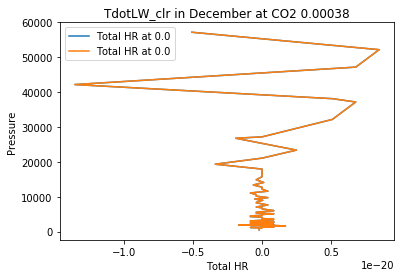

In [208]:
plot_totalHR(time1, time2, 'December')

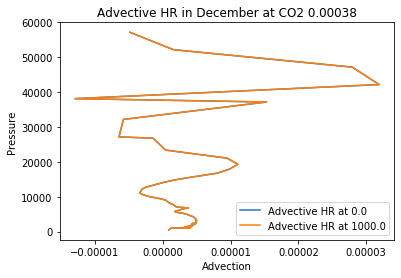

In [213]:
plot_advection(time1,time2, 'December')

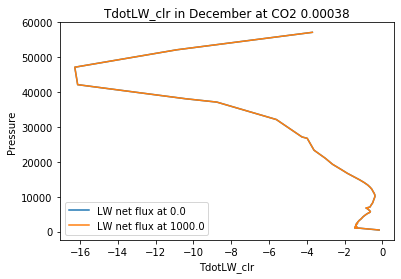

In [214]:
plot_TdotLW_clr(time1, time2, 'December')

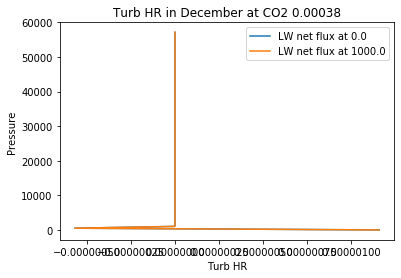

In [215]:
plot_turb_hr(time1, time2, 'December')

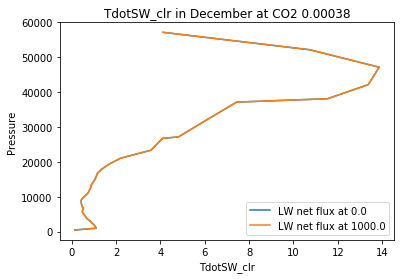

In [216]:
plot_TdotSW_clr(time1, time2, 'December')

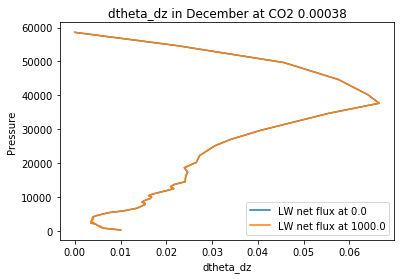

In [217]:
plot_dtheta_dz(time1, time2, 'December')

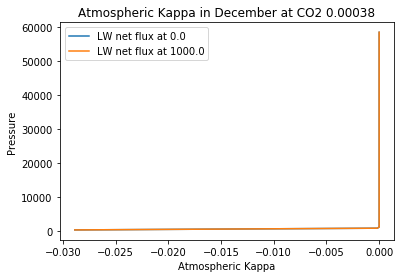

In [218]:
plot_atmdiffk(time1, time2, 'December')

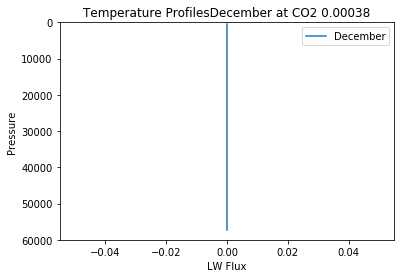

In [219]:
plot_temperature(time1, 200, 'December')

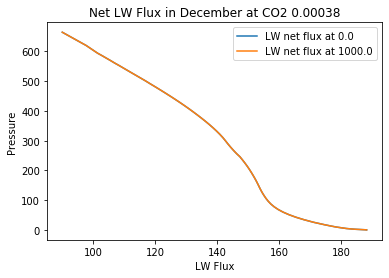

In [220]:
plot_LWnet(time1,time2,'December')

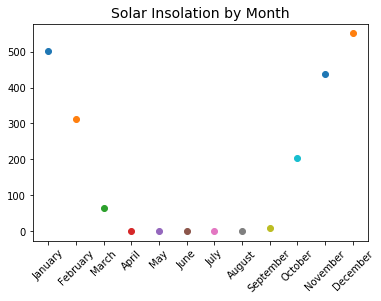

In [221]:
fig, ax = plt.subplots(figsize = [6,4])
for m in months:
    plt.plot(m, ram_dict['strat'][.00038][m].subprocess.Radiation.insolation, 'o')
    plt.xticks(rotation = 45)
    plt.title('Solar Insolation by Month', fontsize = 14)